In [39]:
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import models

import matplotlib.pyplot as plt
import numpy as np

from shutil import copyfile

In [52]:
# visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# and unpack in current folder

# Проверяем, что файлы есть

print(len(os.listdir('PetImages/Cat/')))
assert len(os.listdir('PetImages/Cat/')) > 0
print(len(os.listdir('PetImages/Dog/')))
assert len(os.listdir('PetImages/Dog/')) > 0


12501
12501


In [41]:
# Папки для обучения
try:
    os.mkdir('training')
    os.mkdir('testing')
    os.mkdir('training/cats')
    os.mkdir('training/dogs')
    os.mkdir('testing/cats')
    os.mkdir('testing/dogs')
except OSError:
    pass


In [42]:
# Функция разделения данных на обучающую и тестовую выборку
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "PetImages/Cat/"
TRAINING_CATS_DIR = "training/cats/"
TESTING_CATS_DIR = "testing/cats/"
DOG_SOURCE_DIR = "PetImages/Dog/"
TRAINING_DOGS_DIR = "training/dogs/"
TESTING_DOGS_DIR = "testing/dogs/"

if len(os.listdir('training/cats/')) == 0: # Если данных ещё нет, подготавилваем
    split_size = .9 # Коэффициент обучающей и тестовой выборки
    split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
    split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [43]:
print(len(os.listdir('training/cats/')))
assert len(os.listdir('training/cats/'))
print(len(os.listdir('training/dogs/')))
assert len(os.listdir('training/dogs/'))
print(len(os.listdir('testing/cats/')))
assert len(os.listdir('testing/cats/'))
print(len(os.listdir('testing/dogs/')))
assert len(os.listdir('testing/dogs/'))


11250
11250
1250
1250


In [6]:
# Создаем модель Keras
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # ТОЛЬКО 1 ВЫХОДНОЙ НЕЙРОН. БУДЕТ СОДЕРЖАТЬ ЗНАЧЕНИЕ ОТ 0-1 ГДЕ 0 ДЛЯ 1-ГО КЛАССА ('кошки') И 1 ДЛЯ ВТОРОГО ('собаки')
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Функция потерь (Loss function) — измеряет точность модели во время обучения.
# Оптимизатор (Optimizer) — показывает каким образом обновляется модель на основе входных данных и функции потерь.
# Метрики (Metrics) — используются для мониторинга тренировки и тестирования модели. Наш пример использует метрику accuracy равную доле правильно классифицированных изображений.

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 32)        1

In [7]:
# Подготовка данных

TRAINING_DIR = "training"
train_datagen = ImageDataGenerator( rescale = 1.0/255. ) #Приводит байты к диапазону от 0 до 1
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(300, 300))

VALIDATION_DIR = "testing"
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(300, 300))


Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [8]:
print('Значения выходного классификатора', train_generator.class_indices)

Значения выходного классификатора {'cats': 0, 'dogs': 1}


In [9]:
MODEL_PATH = './models'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

In [10]:
# Запускаем модель и смотрим историю обучения
checkpoint_path = f'{MODEL_PATH}/model.hdf5'
checkpointer = ModelCheckpoint( # Сохраняет наилучшую модель, в случае сбоя продолжить.
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)
callbacks = [checkpointer] #
history = model.fit(train_generator,
                              epochs=10,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=validation_generator)



Epoch 1/10
352/352 [==============================] - ETA: 0s - loss: 0.6353 - accuracy: 0.6278   

Text(0.5, 1.0, 'Training and validation loss')

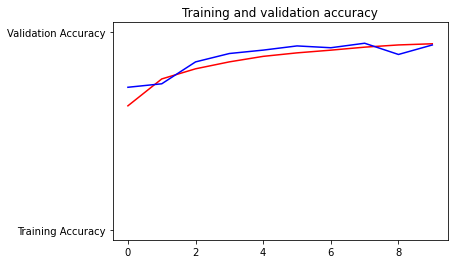

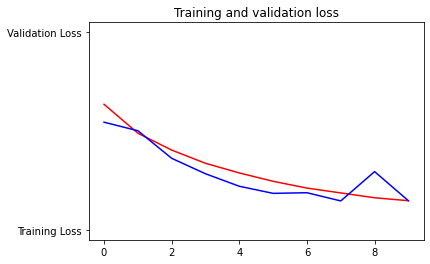

In [51]:
# График истории и точности

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [45]:
# Загружаем лучшую модель
model.load_weights(checkpoint_path)

test_images/05008527_C.jpg
[0.00062376]
05008527_C.jpg is a cat
test_images/2f065f_D.jpg
[1.]
2f065f_D.jpg is a dog
test_images/7c68_C.jpg
[0.]
7c68_C.jpg is a cat
test_images/default_D.jpg
[1.]
default_D.jpg is a dog
test_images/dicas_D.png
[1.]
dicas_D.png is a dog
test_images/dog_D.jpg
[1.]
dog_D.jpg is a dog
test_images/hqdefault_C.jpg
[0.9354662]
hqdefault_C.jpg is a dog
test_images/image1_C.jpg
[0.]
image1_C.jpg is a cat
test_images/jpg_q50_D.jpg
[1.]
jpg_q50_D.jpg is a dog
test_images/post-C.jpg
[1.]
post-C.jpg is a dog


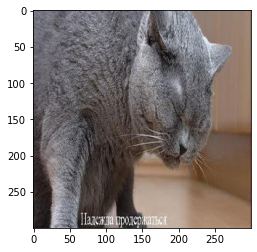

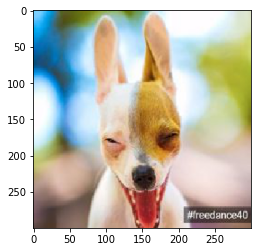

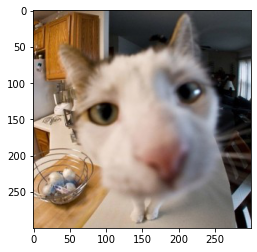

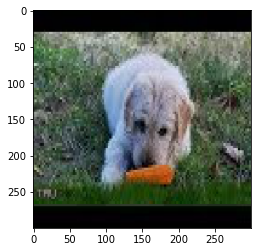

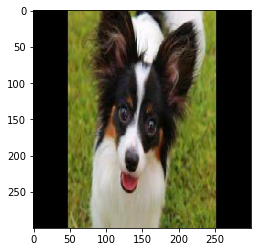

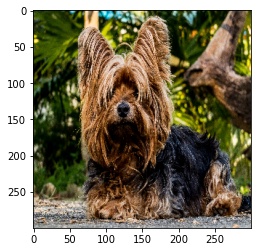

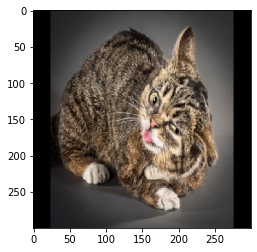

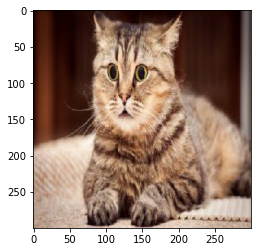

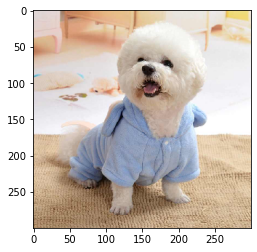

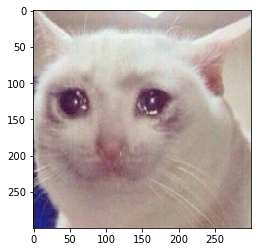

In [46]:
for fn in os.listdir('test_images'):

  # predicting images
  path = 'test_images/' + fn
  print(path)
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  img_tensor = x / 255.
  plt.imshow(img_tensor[0])
  plt.show()

  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

(1, 300, 300, 3)


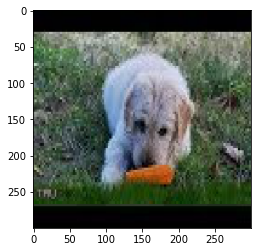

In [47]:
# Первая картинка
img_path = 'test_images/' + 'default_D.jpg' #'05008527_C.jpg' # default_D.jpg
img = image.load_img(img_path, target_size=(300, 300))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Изображение нужно приводить к диапазону [0,1]
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

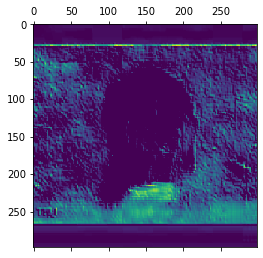

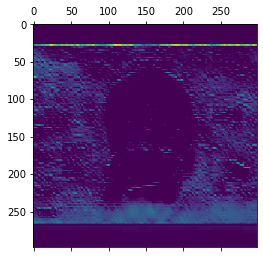

In [48]:
# Первый слой картинки 1й и 15й фильтр (функция активации)
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
acts = activation_model.predict(img_tensor)
first_layer_activation = acts[0]
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

<ipython-input-49-ae78df187f7e>:20: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


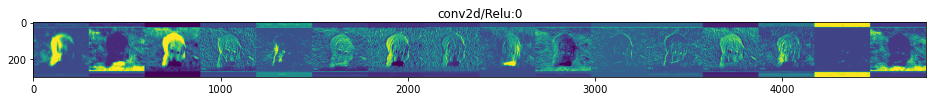

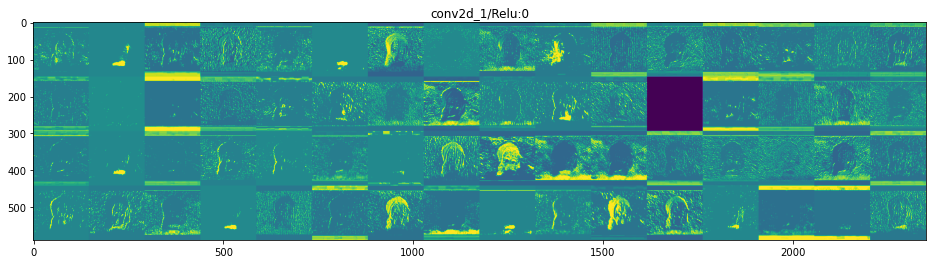

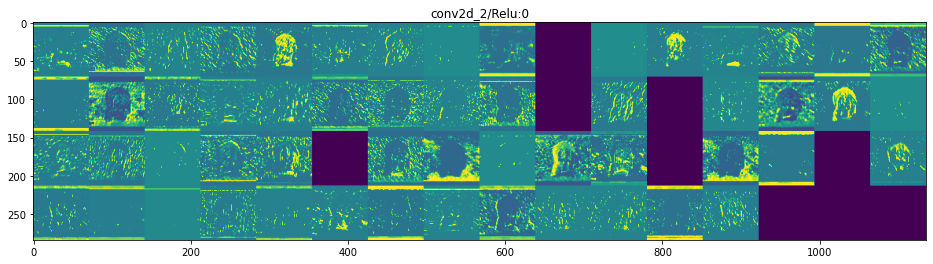

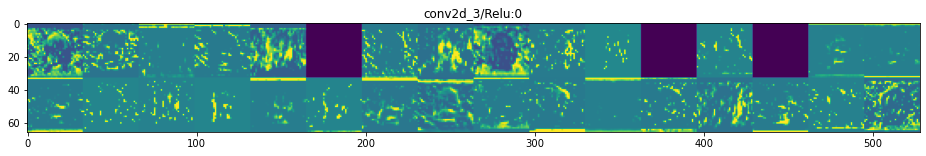

In [49]:
images_per_row = 16
for layer_output, layer_activation in zip(layer_outputs, acts):
    if not layer_output.name.startswith('max'):
        # Количество фильтров в карте признаков
        n_features = layer_activation.shape[-1]
        # Признак имеет форму: (1, высота, ширина, n_features)
        size = layer_activation.shape[1]
        # Разместим результаты активации в виде сетки.
        # На каждой строке будет по images_per_row (16)
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                # Фильтр:
                channel_image = layer_activation[0,
                                                :, :,
                                                col * images_per_row + row]
                # Постобработка, чтобы получить приемлимую визуализацию
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        # Визуализация результатов активации модели TensorFlow
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_output.name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()